## Imports

In [1]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

2024-03-03 19:52:47.193029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 19:52:47.193085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 19:52:47.194573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Utilities

In [3]:
from pickle import load

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = load(fo, encoding='latin1')
    return dict

In [4]:
def read_data(filename):
    data = unpickle(f"/kaggle/input/cifar-10/{filename}")
    df = DataFrame(list(data.items()), columns=["Keys", "Values"])
    return data, df

In [5]:
def print_red(skk): print("\033[91m {}\033[00m" .format(skk))
def print_green(skk): print("\033[92m {}\033[00m" .format(skk))
def print_yellow(skk): print("\033[93m {}\033[00m" .format(skk))
def print_purple(skk): print("\033[95m {}\033[00m" .format(skk))
def print_cyan(skk): print("\033[96m {}\033[00m" .format(skk))

In [6]:
def plot_metrics(title, xlabel, ylabel, history, metric1, metric2):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

def plot_accuracy_validation_precision(history):
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plot_metrics('Training and Validation Accuracy', 'Epoch', 'Accuracy', history, 'accuracy', 'val_accuracy')

    plt.subplot(2, 2, 2)
    plot_metrics('Training and Validation Loss', 'Epoch', 'Loss', history, 'loss', 'val_loss')

    plt.subplot(2, 2, 3)
    plot_metrics('Training and Validation Precision', 'Epoch', 'Precision', history, 'precision', 'val_precision')

    plt.tight_layout()
    plt.show()

In [7]:
def display_model_hyperparameters(total_epochs, lr, weight_decay):
    print_cyan(f"Total Epochs: {total_epochs}")
    print_cyan(f"Learning Rate: {lr}")
    print_cyan(f"Weight Decay: {weight_decay}")

In [8]:
from sklearn.metrics import accuracy_score

def display_model_stats(history, X_test, y_test):
    
    results = model_adam.predict(X_test)
    preds_cls_idx = results.argmax(axis=-1)
    test_accuracy = accuracy_score(y_test, preds_cls_idx)
    
    train_acc = history_adam.history['accuracy'][-1] * 100
    val_acc = history_adam.history['val_accuracy'][-1] * 100
    print_green(f"Training accuracy: {train_acc : .2f}%")
    print_green(f"Validation accuracy: {val_acc : .2f}%")
    print_green(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    print_red(f"Training loss: {history_adam.history['loss'][-1] : .3f}")
    print_red(f"Validation loss: {history_adam.history['val_loss'][-1] : .3f}")
    
    return int(train_acc), int(val_acc), int(test_accuracy * 100)
    

In [9]:
def save_model(train_acc, val_acc, test_acc, accuracy_threshold):
    if (train_acc and val_acc and test_acc ) > int(accuracy_threshold):
        print_yellow("Saving model....")
        model_name = f"model-{train_acc}-{val_acc}-{test_acc}.h5"
        model_adam.save(model_name)
        print_yellow(f"Model Saved With Name {model_name}!!")
    else:
        print_red("Didnt save because accuracy was lesser than 80 !")

## Data

### Reading Labels

In [10]:
# read labels
labels_data, labels_df = read_data("batches.meta")
labels_df

,Keys,Values
0,num_cases_per_batch,10000
1,label_names,"[airplane, automobile, bird, cat, deer, dog, f..."
2,num_vis,3072


In [11]:
labels = labels_data["label_names"]
all_labels_df = DataFrame(labels, columns=["Labels"])
all_labels_df

,Labels
0,airplane
1,automobile
2,bird
3,cat
4,deer
5,dog
6,frog
7,horse
8,ship
9,truck


### Reading Data

In [12]:
import numpy as np

# Assuming your data looks like this (adjust accordingly)
data1, df1 = read_data("data_batch_1")
data2, df2 = read_data("data_batch_2")
data3, df3 = read_data("data_batch_3")
data4, df4 = read_data("data_batch_4")
data5, df5 = read_data("data_batch_5")

test_data, test_df = read_data("test_batch")

# Combine data
dataset = np.concatenate([data1["data"], data2["data"], data3["data"], data4["data"], data5["data"]], axis=0)
dataset_labels = np.concatenate([data1["labels"], data2["labels"], data3["labels"], data4["labels"], data5["labels"]], axis=0)

print("Combined Data Shape:", dataset.shape)
print("Combined Labels Length:", len(dataset_labels))

test_dataset = test_data["data"]
test_dataset_labels = test_data["labels"]

print("Test Data Shape: ", test_dataset.shape)
print("Test Data Labels Length: ", len(test_dataset_labels))




Combined Data Shape: (50000, 3072)
Combined Labels Length: 50000
Test Data Shape:  (10000, 3072)
Test Data Labels Length:  10000


In [13]:
# reshape images while taking channel first then rearrange to height, width, channel
dataset = dataset.reshape(len(dataset),3,32,32).transpose(0,2,3,1)
print(dataset.shape)

test_dataset = test_dataset.reshape(len(test_dataset),3,32,32).transpose(0,2,3,1)
print(test_dataset.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [14]:
def display_dataset_images(temp_data, temp_labels,images_per_label=10 ):
    unique_image_labels = set(temp_labels)

    for current_label in unique_image_labels:
        # get indices of images with current label
        current_label_indices = [current_image_index for current_image_index, current_image_label in enumerate(temp_labels) if current_image_label == current_label]

        current_label_random_indices = random.sample(current_label_indices, images_per_label)

        fig, axes = plt.subplots(1, images_per_label, figsize=(12, 1.5))
        fig.suptitle(f"Label: {labels[current_label]}")

        for i, index in enumerate(current_label_random_indices):
            axes[i].imshow(temp_data[index])
            axes[i].axis('off')

        plt.show()

In [15]:
# display_dataset_images(dataset, dataset_labels)

## Data Preprocessing

### Normalization

In [16]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_train_normalized = dataset / 255.0
X_test_normalized = test_dataset / 255.0

y_train = to_categorical(dataset_labels)
y_test = test_dataset_labels

X_train_normalized = np.array(X_train_normalized)
X_test_normalized = np.array(X_test_normalized)

# create validation set
X_train_normalized, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, test_size=0.2, random_state=42)

# print shapes
print("X_train_normalized shape:", X_train_normalized.shape)
print("X_test_normalized shape:", X_test_normalized.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", len(y_test))
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)


X_train_normalized shape: (40000, 32, 32, 3)
X_test_normalized shape: (10000, 32, 32, 3)
y_train shape: (40000, 10)
y_test shape: 10000
X_validation shape: (10000, 32, 32, 3)
y_validation shape: (10000, 10)


### Data Augmentation

In [17]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_normalized)

### Images Data After Normalization

In [18]:
# display_dataset_images(X_train_normalized, y_train)

## Model Building

### Model Structure

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from keras.regularizers import l2
from keras import optimizers
from keras.metrics import TopKCategoricalAccuracy, Precision, Recall, AUC

def get_cnn_model():
    model = Sequential()
    model.add(Conv2D(96, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())

    model.add(Conv2D(96, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(96, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(192, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(192, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(192, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    return model


In [20]:
total_epochs = 60
lr = 0.01
weight_decay = lr / total_epochs
momentum = 0.9

display_model_hyperparameters(total_epochs, lr, weight_decay)

 Total Epochs: 60
 Learning Rate: 0.01
 Weight Decay: 0.00016666666666666666


In [21]:
model_adam = get_cnn_model()

metrics = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    TopKCategoricalAccuracy(k=5, name='top5_accuracy'),
]

optimizer = optimizers.SGD(learning_rate=lr, momentum = momentum, decay = weight_decay, nesterov = True)

model_adam.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
model_adam.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,397,386 (5.33 MB)

 Trainable params: 1,395,402 (5.32 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Model Training

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10, 
    restore_best_weights=True
)
checkpoint = ModelCheckpoint('best_model.h5.keras', monitor='val_accuracy', save_best_only=True)

In [23]:
start_time = time.time()
print_yellow(f"Training started at {start_time}")

history_adam = model_adam.fit(
    datagen.flow(X_train_normalized, y_train),
    validation_data=(X_validation, y_validation),
    epochs = total_epochs,
    callbacks = [
        early_stopping,
        checkpoint,
    ]
)

 Training started at 1709495573.5526693
Epoch 1/60
   7/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.0961 - auc: 0.5084 - loss: 3.7474 - precision: 0.0897 - recall: 0.0480 - top5_accuracy: 0.4967          

I0000 00:00:1709495587.107527     723 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709495587.128193     723 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3424 - auc: 0.7895 - loss: 1.9236 - precision: 0.4631 - recall: 0.1634 - top5_accuracy: 0.8383

W0000 00:00:1709495617.475952     723 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 26ms/step - accuracy: 0.3426 - auc: 0.7896 - loss: 1.9228 - precision: 0.4634 - recall: 0.1636 - top5_accuracy: 0.8384 - val_accuracy: 0.5260 - val_auc: 0.8981 - val_loss: 1.3351 - val_precision: 0.6916 - val_recall: 0.3834 - val_top5_accuracy: 0.9346
Epoch 2/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5016 - auc: 0.8903 - loss: 1.3861 - precision: 0.6557 - recall: 0.3230 - top5_accuracy: 0.9303 - val_accuracy: 0.6020 - val_auc: 0.9262 - val_loss: 1.1430 - val_precision: 0.7190 - val_recall: 0.4842 - val_top5_accuracy: 0.9535
Epoch 3/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5776 - auc: 0.9188 - loss: 1.1938 - precision: 0.7138 - recall: 0.4261 - top5_accuracy: 0.9528 - val_accuracy: 0.6486 - val_auc: 0.9434 - val_loss: 0.9940 - val_precision: 0.7761 - val_recall: 0.5400 - val_top5_accuracy: 0.9650
Epoch 4/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6255 - auc: 0.9352 - loss: 1.0659 - precision: 

In [24]:
end_time = time.time()
print_yellow(f"Training ended at {end_time / 60}")
time_taken = (round(end_time - start_time, 2) / 60 )
print_yellow(f"Total time taken for training: {time_taken} mins")

 Training ended at 28491623.740798496
 Total time taken for training: 30.848333333333336 mins


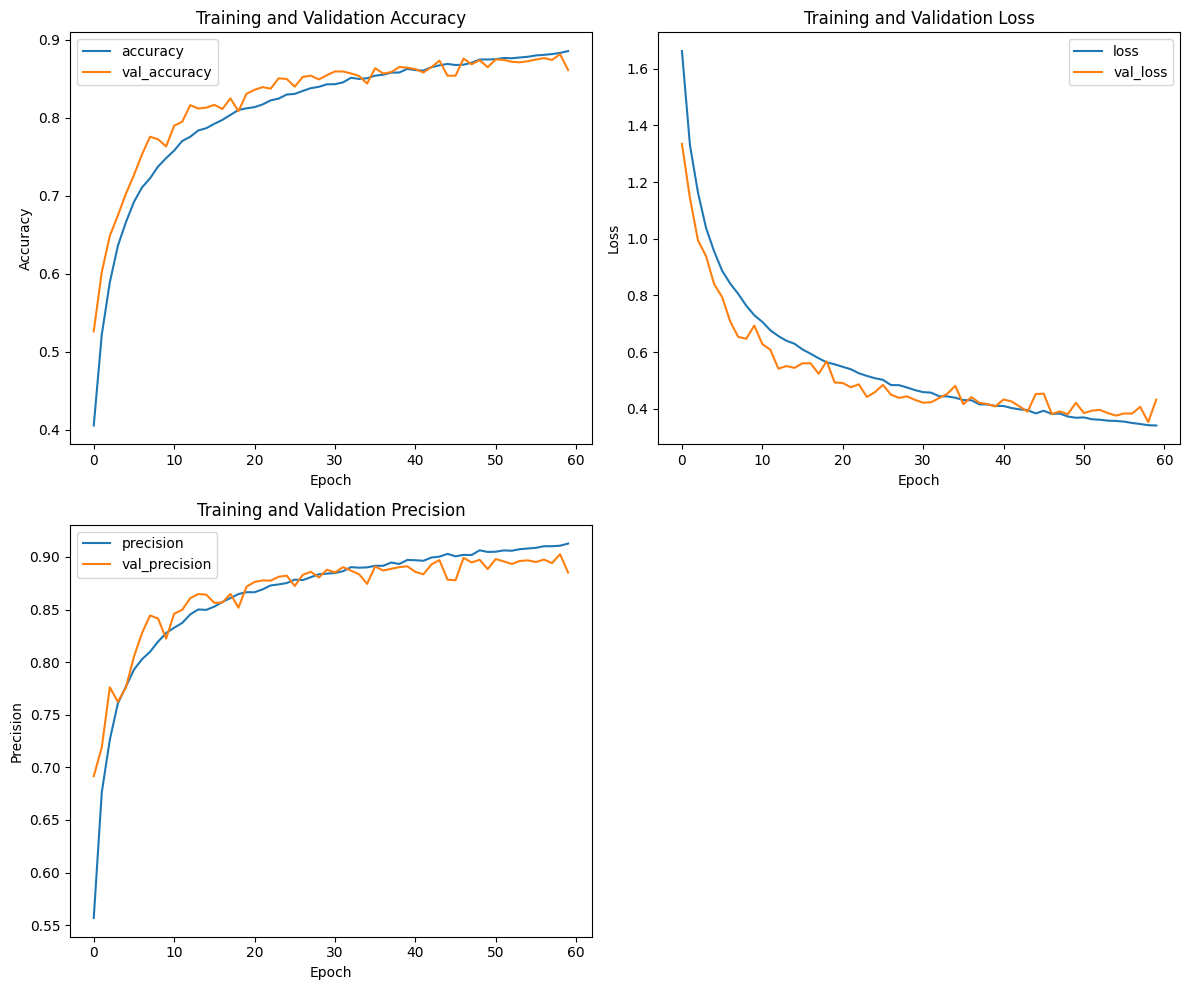

In [25]:
plot_accuracy_validation_precision(history_adam)

## Model Evaluation

In [26]:
train_acc, val_acc, test_acc = display_model_stats(history_adam, X_test_normalized, y_test)
save_model(train_acc, val_acc, test_acc, 80)

 85/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1709497426.467463     722 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 Training accuracy:  88.56%
 Validation accuracy:  86.13%
 Test Accuracy: 88.11%
 Training loss:  0.341
 Validation loss:  0.433
 Saving model....
 Model Saved With Name model-88-86-88.h5!!


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Axes: >

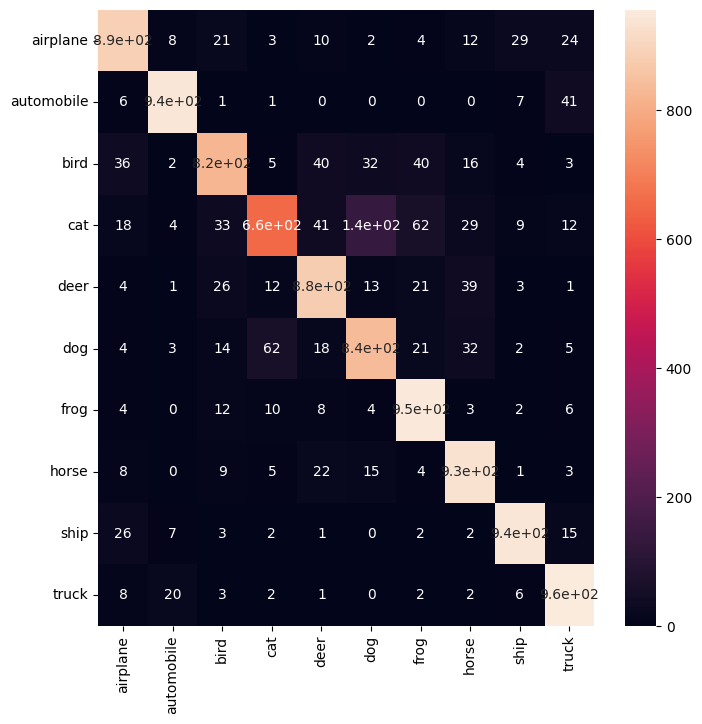

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship", "truck"]

y_pred  = model_adam.predict(X_test_normalized).argmax(1)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(conf_mat, annot=True,  xticklabels=class_names, yticklabels = class_names)
